## INFO https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3951655/

In [135]:
%%capture
!pip install datasets
!pip install sentencepiece
!pip install dataprep
!pip install simpletransformers
!pip install colorama

In [136]:
from simpletransformers.ner import NERModel, NERArgs

In [137]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import keras.backend as K


from dataprep.eda import plot, plot_correlation, create_report, plot_missing
from pprint import pprint


In [138]:
from colorama import Fore

def print_color(prediction):
  for sentence in prediction[0]:
    for key, val in sentence.items():
      if val == '0':
        print(Fore.GREEN + key + ' - 0')
      if val == '1':
        print(Fore.BLUE + key + ' - 1')
      if val == '2':
        print(Fore.RED + key + ' - 2')

#### The NCBI Disease corpus consists of 793 PubMed abstracts, which are separated into training (593), development (100) and test (100) subsets. The NCBI Disease corpus is annotated with disease mentions, using concept identifiers from either MeSH or OMIM.

In [139]:
from datasets import load_dataset
dataset = load_dataset("ncbi_disease")

Reusing dataset ncbi_disease (/root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/88b09d40ea6f23141af303fa5f80b07d7de87612b2e41f494f537c4eff97372c)


In [140]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [141]:
df_train = pd.DataFrame(dataset['train'])
df_valid = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

In [142]:
eda_df = pd.concat([df_train,df_valid,df_test], ignore_index=True)
eda_df.shape

(7298, 3)

### ner_tags: Array of tags, where 0 indicates no disease mentioned, 1 signals the first token of a disease and 2 the subsequent disease tokens. 

In [143]:
df_train

,id,ner_tags,tokens
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[Identification, of, APC2, ,, a, homologue, of..."
1,1,"[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[The, adenomatous, polyposis, coli, (, APC, ),..."
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[Complex, formation, induces, the, rapid, degr..."
3,3,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, colon, carcinoma, cells, ,, loss, of, APC..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Here, ,, we, report, the, identification, and..."
...,...,...,...
5428,5428,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Here, ,, we, show, that, retroviral, transfer..."
5429,5429,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, ...","[Mutant, BRCA1, has, no, effect, on, growth, o..."
5430,5430,"[0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Development, of, MCF, -, 7, tumours, in, nude..."
5431,5431,"[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, ...","[Most, importantly, ,, among, mice, with, esta..."


In [144]:
pprint(eda_df['ner_tags'].iloc[0])
pprint(eda_df['tokens'].iloc[0])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]
['Identification',
 'of',
 'APC2',
 ',',
 'a',
 'homologue',
 'of',
 'the',
 'adenomatous',
 'polyposis',
 'coli',
 'tumour',
 'suppressor',
 '.']


In [145]:
# errors
len([1 for ln in eda_df[['ner_tags','tokens']].values 
              if len(ln[0]) != len(ln[1])])

0

In [146]:
# extract mark_2 and mark_1
mark_2 = []
mark_1 = []
mark_0 = []
for w,p in zip(eda_df['ner_tags'].values, eda_df['tokens'].values):
    for idx, ww in enumerate(w):
       if ww == 2:
         mark_2.append(p[idx])
       if ww == 1:
         mark_1.append(p[idx])
       else:
         mark_0.append(p[idx])

In [147]:
# len of each mark
print(len(mark_2))
print(len(mark_1))
print(len(mark_0))

8299
6892
177660


In [148]:
len(np.unique(mark_2))

947

In [149]:
len(np.unique(mark_1))

1154

In [150]:
len(np.unique(mark_0))

10241

In [151]:
pd.value_counts(mark_2)

-                 873
cancer            411
deficiency        345
syndrome          343
disease           329
                 ... 
rhabdoid            1
corporis            1
macula              1
mesothelioma        1
incoordination      1
Length: 947, dtype: int64

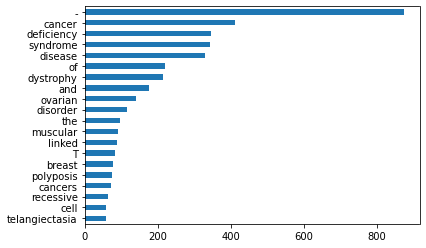

In [152]:
pd.value_counts(mark_2)[:20][::-1].plot(kind='barh')

### '-' ?????

In [153]:
# check '-'
l_=[]
for line in eda_df['tokens'].values:
    for idx, ww in enumerate(line):
        if ww == '-':
          strr= f'{line[idx-1]}{line[idx]}{line[idx+1]}'
          l_.append(strr)


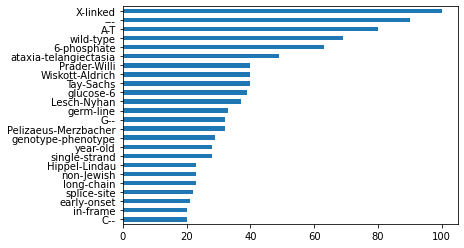

In [154]:
pd.value_counts(l_)[1:25][::-1].plot(kind='barh')

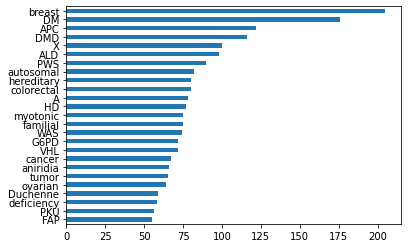

In [155]:
pd.value_counts(mark_1)[:25][::-1].plot(kind='barh')

In [156]:
eda_df['sentences'] = eda_df['tokens'].apply(lambda x: str(x)[1:-1])

In [157]:
import re
def clean_text(text):
    text=' '.join([i for i in text.split(',')])
    text=' '.join([i for i in text.split("'")])
    text=' '.join([i for i in text.split() if i.isalpha()])
    
    return text

In [158]:
eda_df['content'] = eda_df['sentences'].apply(clean_text)
eda_df

,id,ner_tags,tokens,sentences,content
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[Identification, of, APC2, ,, a, homologue, of...","'Identification', 'of', 'APC2', ',', 'a', 'hom...",Identification of a homologue of the adenomato...
1,1,"[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[The, adenomatous, polyposis, coli, (, APC, ),...","'The', 'adenomatous', 'polyposis', 'coli', '('...",The adenomatous polyposis coli APC tumour supp...
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[Complex, formation, induces, the, rapid, degr...","'Complex', 'formation', 'induces', 'the', 'rap...",Complex formation induces the rapid degradatio...
3,3,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, colon, carcinoma, cells, ,, loss, of, APC...","'In', 'colon', 'carcinoma', 'cells', ',', 'los...",In colon carcinoma cells loss of APC leads to ...
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Here, ,, we, report, the, identification, and...","'Here', ',', 'we', 'report', 'the', 'identific...",Here we report the identification and genomic ...
...,...,...,...,...,...
7293,936,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, an, attempt, to, resolve, this, issue, ,,...","'In', 'an', 'attempt', 'to', 'resolve', 'this'...",In an attempt to resolve this issue we have co...
7294,937,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[These, reagents, detect, a, 220, -, kD, prote...","'These', 'reagents', 'detect', 'a', '220', '-'...",These reagents detect a kD protein localized i...
7295,938,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Immunohistochemical, staining, of, human, bre...","'Immunohistochemical', 'staining', 'of', 'huma...",Immunohistochemical staining of human breast s...
7296,939,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Conversely, ,, BRCA1, expression, was, reduce...","'Conversely', ',', 'BRCA1', 'expression', 'was...",Conversely expression was reduced or undetecta...


In [159]:
df_train = pd.DataFrame(eda_df)

In [160]:
# metafeatures
df_train['word_count'] = df_train['content'].apply(lambda x: len(str(x).split()))
df_train['unique_word_count'] = df_train['content'].apply(lambda x: len(set(str(x).split())))
df_train['stop_word_count'] = df_train['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_train['mean_word_length'] = df_train['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_train['char_count'] = df_train['content'].apply(lambda x: len(str(x)))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [161]:
df_train.columns

Index(['id', 'ner_tags', 'tokens', 'sentences', 'content', 'word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count'], dtype='object')

In [162]:
df_stat = df_train.drop(['id', 'ner_tags', 'tokens', 'sentences','content'], axis=1)

In [163]:
df_stat.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count
count,7298.000000,7298.000000,7298.000000,7219.000000,7298.000000
mean,20.279666,18.186626,7.780214,5.507948,130.191285
std,10.013956,7.961982,4.502393,0.900552,63.979752
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,13.000000,5.000000,5.000000,87.000000
50%,19.000000,18.000000,7.000000,5.454545,124.000000
75%,26.000000,23.000000,10.000000,6.000000,167.000000
max,83.000000,57.000000,38.000000,13.000000,522.000000



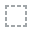
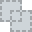
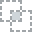
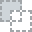
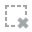
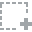
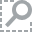
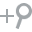
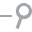
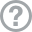
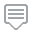
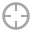
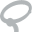
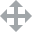
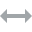
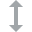
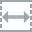
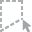
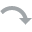
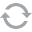
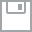
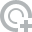
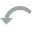
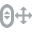
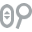
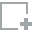
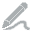
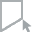
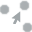
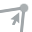
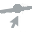

In [164]:
# plot
plot(df_stat)

DataPrep Report
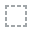
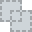
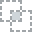
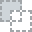
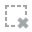
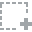
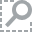
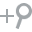
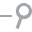
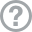
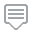
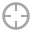
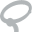
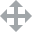
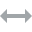
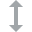
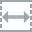
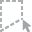
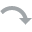
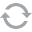
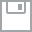
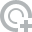
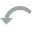
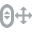
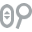
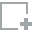
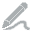
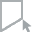
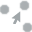
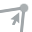
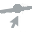

In [165]:
create_report(df_stat)

## Preproc

In [166]:
eda_df = eda_df.drop(['id'],axis = 1)

In [167]:
eda_df['id'] = pd.Series(eda_df.index.values)

In [168]:
eda_df=eda_df.iloc[:7297]

In [221]:
%%capture
da = pd.DataFrame()
k = 0
for i in zip(eda_df['ner_tags'][:1], eda_df['tokens'][:1]):
  df = pd.DataFrame(np.vstack(i[0]), np.vstack(i[1]))
  df.columns=['tags']
  df['id'] = k
  k +=1
  df = df.reset_index()
  da = df
  break
  
for i in zip(eda_df['ner_tags'][1:], eda_df['tokens'][1:]):
  df = pd.DataFrame(np.vstack(i[0]), np.vstack(i[1]))
  df.columns=['tags']
  df['id'] = k
  k +=1
  df = df.reset_index()
  da = pd.concat([da,df], axis=0)

In [170]:
da['index'] = da['index'].apply(lambda x: x[0])

In [171]:
da

,index,tags,id
0,Identification,0,0
1,of,0,0
2,APC2,0,0
3,",",0,0
4,a,0,0
...,...,...,...
27,and,0,5431
28,increased,0,5431
29,survival,0,5431
30,.,0,5431


In [172]:
da.rename(columns={"index":"words","tags":"labels","id":"sentence_id"}, inplace =True)

## Bi-LSTM

In [173]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["words"].values.tolist(),
                                                        s["labels"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [174]:
getter = SentenceGetter(da)

In [175]:
sentences = getter.sentences
print(sentences[25])

[('These', 0), ('intersex', 0), ('differences', 0), ('in', 0), ('colorectal', 1), ('cancer', 2), ('risks', 0), ('have', 0), ('implications', 0), ('for', 0), ('screening', 0), ('programmes', 0), ('and', 0), ('for', 0), ('attempts', 0), ('to', 0), ('identify', 0), ('colorectal', 1), ('cancer', 2), ('susceptibility', 0), ('modifiers', 0), ('.', 0)]


In [176]:
words = list(set(da["words"].values))
words.append("ENDPAD")

In [177]:
n_words = len(words); n_words

9285

In [178]:
tags = list(set(da["labels"].values))

In [179]:
n_tags = len(tags); n_tags

3

In [180]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [199]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [200]:
X = pad_sequences(maxlen=80, sequences=X, padding="post",value=n_words - 1)

In [201]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

[('The', 0), ('positive', 0), ('control', 0), ('for', 0), ('DMT1', 0), ('up', 0), ('-', 0), ('regulation', 0), ('was', 0), ('a', 0), ('murine', 0), ('model', 0), ('of', 0), ('dietary', 1), ('iron', 2), ('deficiency', 2), ('that', 0), ('demonstrated', 0), ('greatly', 0), ('increased', 0), ('levels', 0), ('of', 0), ('duodenal', 0), ('DMT1', 0), ('(', 0), ('IRE', 0), (')', 0), ('mRNA', 0), ('.', 0)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [202]:
y = pad_sequences(maxlen=80, sequences=y_idx, padding="post", value=tag2idx[0])


In [203]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [205]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [206]:
X_train

array([[1806, 7023, 3926, ..., 9284, 9284, 9284],
       [4932, 2128, 4706, ..., 9284, 9284, 9284],
       [1806, 8980, 5586, ..., 9284, 9284, 9284],
       ...,
       [4531, 8478,  960, ..., 9284, 9284, 9284],
       [2400, 5813, 5343, ..., 9284, 9284, 9284],
       [6917, 5352, 2030, ..., 9284, 9284, 9284]], dtype=int32)

In [207]:
input = Input(shape=(80,))
model = Embedding(input_dim=n_words, output_dim=80, input_length=90)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

Layer lstm_4 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Layer lstm_4 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Layer lstm_4 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [208]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [209]:
model = Model(input, out)

In [210]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [211]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=2, validation_split=0.2, verbose=1)

Epoch 1/2
109/109 [==============================] - 85s 734ms/step - loss: 0.3344 - accuracy: 0.9427 - val_loss: 0.0905 - val_accuracy: 0.9735
Epoch 2/2
109/109 [==============================] - 79s 723ms/step - loss: 0.0732 - accuracy: 0.9762 - val_loss: 0.0507 - val_accuracy: 0.9829


### prediction and results

In [220]:
p = model.predict(np.array([X_test[6]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

[0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Word          : (True ): Pred
Co            : (    0): 0
-             : (    0): 0
amplification : (    0): 0
of            : (    0): 0
11            : (    0): 0
exons         : (    0): 0
from          : (    0): 0
genomic       : (    0): 0
DNA           : (    0): 0
of            : (    0): 0
Duchenne      : (    1): 1
and           : (    2): 0
Becker        : (    2): 1
muscular      : (    2): 2
dystrophy     : (    2): 2
(             : (    0): 2
DMD           : (    1): 2
/             : (    0): 2
BMD           : (    1): 2
)             : (    0): 0
patients      : (    0): 0
with          : (    0): 0
no            : (    0): 0
deletion      : (    0): 0
or            : (    0): 0
duplication   : (    0): 0
was           : (    0): 0
performed     : (    0): 0
and           : (    0): 0
the           : (    0)

## BERT NER

In [223]:
X = da[["sentence_id","words"]]
Y = da["labels"]

In [224]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.15)

In [225]:
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [226]:
train_data.labels = train_data['labels'].apply(lambda x: str(x))
test_data.labels = test_data['labels'].apply(lambda x: str(x))

In [227]:
label = train_data["labels"].unique().tolist()
label

['0', '2', '1']

In [228]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 32
args.eval_batch_size = 32

In [232]:
model = NERModel('bert', 'bert-base-cased', labels=label, args=args)

In [68]:
model.train_model(train_data, eval_data=test_data,acc=f1_score)

 Converting to features started.


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Training of bert model complete. Saved to outputs/.


(170, 0.16781110579476638)

In [233]:
result, model_outputs, preds_list = model.eval_model(test_data)

In [70]:
df_train.loc[1]

id                                                                   1
ner_tags             [0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...
tokens               [The, adenomatous, polyposis, coli, (, APC, ),...
sentences            'The', 'adenomatous', 'polyposis', 'coli', '('...
content              The adenomatous polyposis coli APC tumour supp...
word_count                                                          26
unique_word_count                                                   26
stop_word_count                                                      6
mean_word_length                                               6.03846
char_count                                                         182
Name: 1, dtype: object

In [71]:
prediction, model_output = model.predict(["My treasure is adenomatous polyposis coli"])

 Converting to features started.


In [72]:
prediction

[[{'My': '0'},
  {'treasure': '0'},
  {'is': '0'},
  {'adenomatous': '2'},
  {'polyposis': '2'},
  {'coli': '2'}]]

In [73]:
print_color(prediction)

My - 0
treasure - 0
is - 0
adenomatous - 2
polyposis - 2
coli - 2
